# Symbolic computations for the 1D disturbed study

In [147]:
import sympy as sp
sp.init_printing()
import IPython.display as disp
import matplotlib.pyplot as plt
import numpy as np

# 1D
# Continuous piecewise linear functions
drawing = f"""
    .____.________.
    x-1  x0      x1
    |____|________|
      hx-    hx+

"""
print(drawing)


    .____.________.
    x-1  x0      x1
    |____|________|
      hx-    hx+




We will consider real-valued waves, wavenumbers and thus real-valued tau parameters

In [148]:
# !!! Indicates a hypothesis (should be studied and considered)

# !!! Mode selection
mode_values = "real" # real or complex values


SymPy variables for the wavenumbers and space

In [149]:
# Wavenumbers
k = sp.Symbol('k',
              #real=True, # !!!
              #positive=True, # !!!
              )
kh = sp.symbols('k^h')

# 1D variable
x = sp.symbols('x')

The usual bilinear form for our Helmholtz problem.
Integrated over an interval $[a, b]$.

In [150]:

# 1D variational formulations over [a, b]
def a_G(u, v, a, b):
    D_u = sp.diff(u, x)
    D_v = sp.diff(v, x)
    return sp.integrate(D_u*D_v, (x, a, b)) - ( k**2 * sp.integrate(u*v, (x, a, b)) )


SymPy variables for mesh dimensions, as mentioned in the drawing.

In [151]:
# h definitions
h_x_ = dict()
h_x_["-"], h_x_["+"] = sp.symbols('h_x^- h_x^+')
h_x = sp.symbols('h_x')


Point coordinates baed on the mesh dimensions

In [152]:
# Grid sample
x_ = dict()
x_["-1"], x_["0"], x_["+1"] = -h_x_["-"], sp.sympify(0), +h_x_["+"]

Shape functions associated with each node.
Their definitions is only valid over a certain interval.
The shape function associated with the central node has to be defined seperately over each interval.

In [153]:
# Shape functions
N_ = dict()
N_["-1"] = - x / h_x_["-"] # over [x-1, x0]
N_["0-"] = (x / h_x_["-"]) + 1 # over [x-1, x0]
N_["0+"] = (- x / h_x_["+"]) + 1 # over [x0, x+1]
N_["+1"] = x / h_x_["+"] # over [x0, x+1]

Here is what the shape functions look like

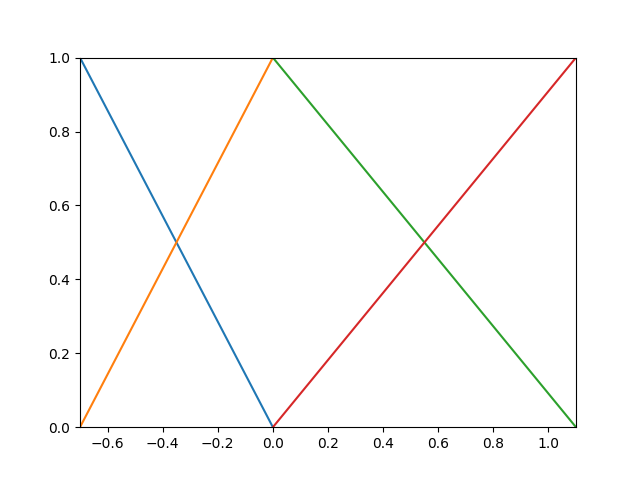

In [154]:
# Plot shape functions

HX_M = 0.7
HX_P = 1.1


X = np.linspace(-HX_M, +HX_P, num=10)

Y = np.zeros((4, len(X)))
Y[0] = sp.lambdify(args=[x, h_x_["-"]], expr=N_["-1"])(X, HX_M)
Y[1] = sp.lambdify([x, h_x_["-"]], N_["0-"])(X, HX_M)
Y[2] = sp.lambdify([x, h_x_["+"]], N_["0+"])(X, HX_P)
Y[3] = sp.lambdify([x, h_x_["+"]], N_["+1"])(X, HX_P)

fig, ax = plt.subplots()
for Yi in Y:
    ax.plot(X, Yi)
ax.set_xlim(xmin=-HX_M, xmax=HX_P)
ax.set_ylim(ymin=0, ymax=1)

We are studying the line $0$ of our discrete system $AU^h=0$.
The equation is:
$$
A_{0, -1}U_{-1}^h + A_{0, 0}U_{0}^h + A_{0, +1}U_{+1}^h = 0
$$
Where
$$
A_{G,ij} = \sum_{e \in E} K_{ij}^e - k^2 M_{ij}^e = \sum_{e \in E} a_{G}^e(N_i, N_j)
$$
$E$ denotes the set of elements whose boundary contains both nodes $i$ and $j$.

The right definition of the shape functions should be used

In [155]:
# Linear system coefficients (Galerkine)
A_G_ = dict()
A_G_["0, -1"] = a_G(N_["0-"], N_["-1"], x_["-1"], x_["0"])
A_G_["0, 0"] = a_G(N_["0-"], N_["0-"], x_["-1"], x_["0"]) + a_G(N_["0+"], N_["0+"], x_["0"], x_["+1"]) # both left and right elements contain both nodes 0 and 0
A_G_["0, +1"] = a_G(N_["0+"], N_["+1"], x_["0"], x_["+1"])

Checkpoint for the linear equation coefficients

Galerkine coefficients


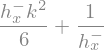

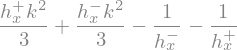

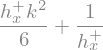

In [156]:

print("Galerkine coefficients")
for a in A_G_.values():
    disp.display(-a)

We assume that the numerical solution can be defined by $u^h(x) = C e^{ik^{h}x}$ where $k^h$ is the numerical wavenumber.

In [157]:
# Numerical solution is supposedly
if mode_values == "complex":
    uh = sp.exp(1j * kh * x)
elif mode_values == "real":
    uh = sp.cos(kh * x)
Uh_ = dict()

# Computing the assumed numerical solution on the right points
Uh_["-1"] = uh.subs(x, x_["-1"])
Uh_["0"] = uh.subs(x, x_["0"])
Uh_["+1"] = uh.subs(x, x_["+1"])

We can now display our linear equation (dispersion relation)

Dispersion relation


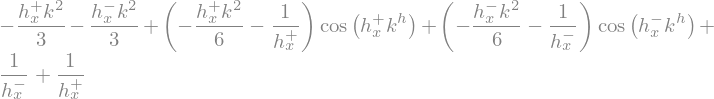

In [158]:
dispersion_relation_G = (A_G_["0, -1"] * Uh_["-1"]) + (A_G_["0, 0"] * Uh_["0"]) + (A_G_["0, +1"] * Uh_["+1"])
print("Dispersion relation")
disp.display(dispersion_relation_G)

Using this dispersion relation, we can solve for $k^2$

Galerkine dispersion
k^2 = 


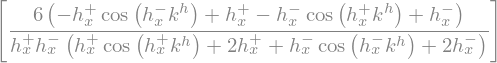

In [159]:
# for k (kh is non analytic in k when hx+ != hx-)
k2_G = sp.solve( dispersion_relation_G, k**2 )
print("Galerkine dispersion")
print("k^2 = ")
disp.display(k2_G)
k2_G = k2_G[0]


Alpha variables for asymptotic developments

In [160]:
# Asymptotic results
alpha_ = dict()
alpha_["-"], alpha_["+"] = sp.symbols('alpha^- alpha^+', real=True, positive=True)


Asymptotic versions of our cosines

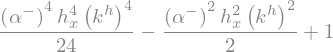

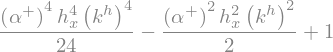

In [161]:
cos_asymptotic_ = dict()
cos_asymptotic_["-"] = sp.sympify(1) - (alpha_["-"]**2/2) * (h_x*kh)**2 + (alpha_["-"]**4/24) * (h_x*kh)**4
cos_asymptotic_["+"] = sp.sympify(1) - (alpha_["+"]**2/2) * (h_x*kh)**2 + (alpha_["+"]**4/24) * (h_x*kh)**4
disp.display(cos_asymptotic_["-"])
disp.display(cos_asymptotic_["+"])


Substituting the cosines in our $k^2$ expression

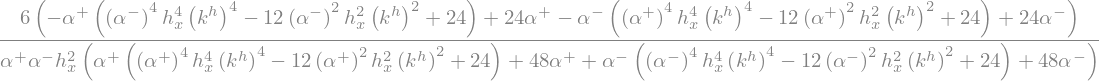

In [162]:
k2_G_asymptotic = k2_G.subs([(sp.cos(h_x_["-"]*kh), cos_asymptotic_["-"]),
                             (sp.cos(h_x_["+"]*kh), cos_asymptotic_["+"])]).subs([
                                 (h_x_["-"], alpha_["-"]*h_x),
                                 (h_x_["+"], alpha_["+"]*h_x)
                             ]).simplify()
disp.display(k2_G_asymptotic)

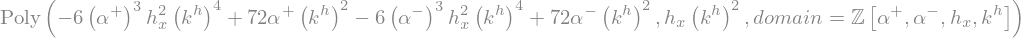

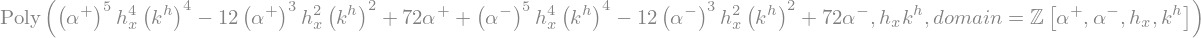

In [163]:
k2_G_asymptotic_numer, k2_G_asymptotic_denom = k2_G_asymptotic.as_numer_denom()
k2_G_asymptotic_numer = sp.Poly((k2_G_asymptotic_numer/(alpha_["-"]*alpha_["+"]*h_x*h_x)).expand(), h_x*(kh**2))
k2_G_asymptotic_denom = sp.Poly((k2_G_asymptotic_denom/(alpha_["-"]*alpha_["+"]*h_x*h_x)).expand(), h_x*kh)
disp.display(k2_G_asymptotic_numer)
disp.display(k2_G_asymptotic_denom)

Let's check for consistency with the usual results

Galerkine dispersion with hx+ = hx-
k^2 = 


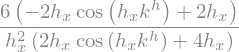

Galerkine dispersion with hx+ = hx-
kh*h = 


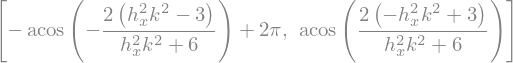

In [164]:
# Check for consistency with hx+ = hx-
k2_G_equal = k2_G.subs(h_x_["+"], h_x).subs(h_x_["-"], h_x)
print("Galerkine dispersion with hx+ = hx-")
print("k^2 = ")
disp.display(k2_G_equal)

# Now k^h is analytic
khh_G_equal = sp.solve(k**2 - k2_G_equal, kh*h_x)
print("Galerkine dispersion with hx+ = hx-")
print("kh*h = ")
disp.display(khh_G_equal)

Calculations give us an asymptotic estimation for the different values of $k^h$ with $k$ varying:
$$
k^h \approx k - \frac{1}{24} \left({\alpha_x^{-}}^2 + {\alpha_x^{+}}^2 - \alpha_x^{-} \alpha_x^{+}\right) k^3 h^2
$$

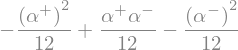

In [165]:
chi = (sp.sympify(-1)/sp.sympify(12)) * (alpha_["-"]**2 + alpha_["+"]**2 - alpha_["-"]*alpha_["+"])
chi_func = sp.lambdify(expr=chi, args=[alpha_["-"], alpha_["+"]])
disp.display(chi)

Here is how $ - \frac{\chi}{2} = \frac{1}{24} \left( {\alpha_x^{-}}^2 + {\alpha_x^{+}}^2 - \alpha_x^{-} \alpha_x^{+} \right)$ looks like with different $\alpha$

<a list of 2 text.Text objects>

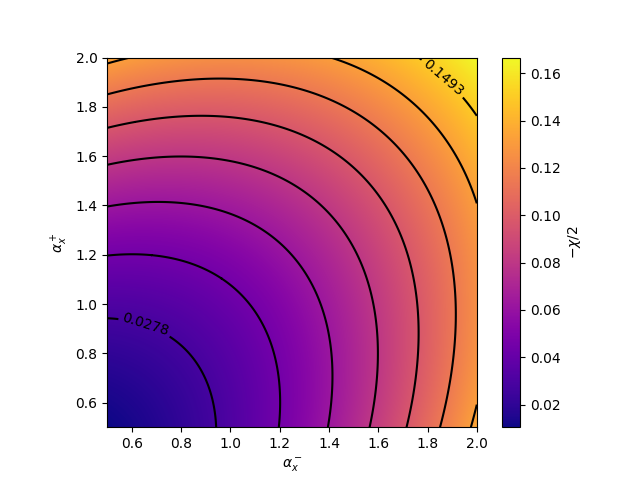

In [166]:
# Parameters
num=1000
alpha_min, alpha_max = 0.5, 2
alpha_range = np.linspace(alpha_min, alpha_max, num=num)

# Square matrices for heatmap values computation
ALPHA_M = np.tile(alpha_range, (num, 1))
ALPHA_P = ALPHA_M.transpose()

# Relevent data for contouring
X, Y = alpha_range, alpha_range
X_mesh, Y_mesh = np.meshgrid(X, Y)

# Computing the coefficient
COEFF = - chi_func(ALPHA_M, ALPHA_P) / 2

# Creating the figure and the axes
fig, ax = plt.subplots()

# Heatmap
im = ax.imshow(COEFF, extent=(alpha_min, alpha_max, alpha_min, alpha_max), cmap=plt.get_cmap('plasma'), aspect='equal', origin='lower')

# Colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label(label=r"$- \chi /2$")

# x and y labels
ax.set_xlabel(r"$\alpha_x^-$")
ax.set_ylabel(r"$\alpha_x^+$")

# Contour lines
levels = np.linspace(COEFF.min(), COEFF.max(), 10)
contour = ax.contour(X_mesh, Y_mesh, COEFF, levels, colors='black', linewidths=1.5)

# Contour labels
ax.clabel(contour, levels=levels[[1, 8]])


Now let's plot and compare the relations between $k$ and $k^h$:
- The first approach uses the exact $k^2$ expression to compute a map from $k^h$ to $k$, who is then reverse-plotted
- The second approach uses the asymptotic $k^h$ expression

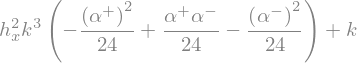

In [167]:
# Exact kh -> k
exact_k_func = sp.lambdify(args=[h_x_["-"], h_x_["+"], kh], expr=sp.sqrt(k2_G))

# Asymptotic k -> kh
kh_G_asymptotic = k + chi/2 * (k**3 * h_x**2)
disp.display(kh_G_asymptotic)
asymptotic_kh_func = sp.lambdify(args=[alpha_["-"], alpha_["+"], h_x, k], expr=kh_G_asymptotic)


Plotting $k^hh$ vs $kh$ with other parameters fixed. The formulae for $k^h$ and $k$ are used and $h$ is set to $1$.

In [168]:
def plot0_1D(ALPHA_M, ALPHA_P, k_min=0, k_max=3):
    
    HX_M = ALPHA_M * 1
    HX_P = ALPHA_P * 1
    
    KH = np.linspace(k_min, k_max, num=200)[1:]
    exact_K = exact_k_func(HX_M, HX_P, KH)

    K = np.linspace(k_min, k_max, num=200)[1:]
    asymptotic_KH = asymptotic_kh_func(ALPHA_M, ALPHA_P, 1, K)
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_title(rf"$\alpha_x^-={ALPHA_M}$, $\alpha_x^+={ALPHA_P}$")
    ax.set_xlabel(r"$k h$")
    ax.set_ylabel(r'$k^h h$')
    ax.plot(exact_K, KH, label="exact (reverse)", linestyle='dotted')
    ax.plot(K, asymptotic_KH, label = "asymptotic", linestyle='dashed')
    ax.plot(K, K, color='black')
    ax.set_xlim(left=k_min, right=k_max)
    ax.set_ylim(bottom=0, top=k_max)
    ax.legend()

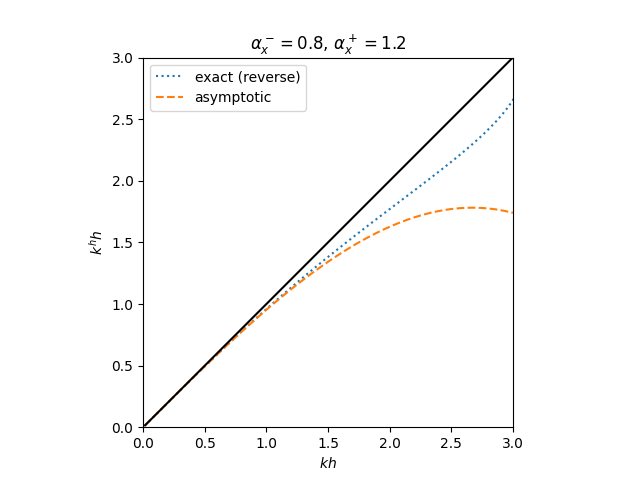

In [169]:
plot0_1D(ALPHA_M=0.8, ALPHA_P=1.2)

Plotting $k^h h - kh$ vs $kh$ with other parameters fixed. Same thing as before to easily obtain the formulae.

In [170]:
def plot1_1D(ALPHA_M, ALPHA_P, k_min=0, k_max=3):
    
    HX_M = ALPHA_M
    HX_P = ALPHA_P
    
    KH = np.linspace(k_min, k_max, num=200)[1:]
    exact_K = exact_k_func(HX_M, HX_P, KH)

    K = np.linspace(k_min, k_max, num=200)[1:]
    asymptotic_KH = asymptotic_kh_func(ALPHA_M, ALPHA_P, 1, K)
    
    fig, ax = plt.subplots()
    ax.set_title(rf"$\alpha_x^-={ALPHA_M}$, $\alpha_x^+={ALPHA_P}$")
    ax.set_xlabel(r"$k h$")
    ax.set_ylabel(r'$k^h h - k h$')
    ax.plot(exact_K, KH-exact_K, label="exact (reverse)", linestyle='dotted')
    ax.plot(K, asymptotic_KH-K, label = "asymptotic", linestyle='dashed')
    ax.set_xlim(left=k_min, right=k_max)
    #ax.set_ylim(bottom=0, top=k_max)
    ax.legend()

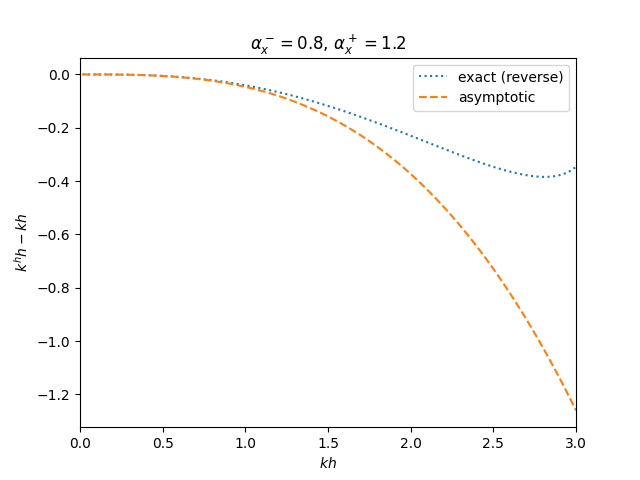

In [171]:
plot1_1D(ALPHA_M=0.8, ALPHA_P=1.2)

Plotting $k^h / k$ vs $kh$ with other parameters fixed. Same thing as before to easily obtain the formulae.

In [172]:
def plot2_1D(ALPHA_M, ALPHA_P, k_min=0, k_max=3):
    
    HX_M = ALPHA_M
    HX_P = ALPHA_P
    
    KH = np.linspace(k_min, k_max, num=200)[1:]
    exact_K = exact_k_func(HX_M, HX_P, KH)

    K = np.linspace(k_min, k_max, num=200)[1:]
    asymptotic_KH = asymptotic_kh_func(ALPHA_M, ALPHA_P, 1, K)
    
    fig, ax = plt.subplots()
    ax.set_title(rf"$\alpha_x^-={ALPHA_M}$, $\alpha_x^+={ALPHA_P}$")
    ax.set_xlabel(r"$kh$")
    ax.set_ylabel(r'$k^h / k$')
    ax.plot(exact_K, KH/exact_K, label="exact (reverse)", linestyle='dotted')
    ax.plot(K, asymptotic_KH/K, label = "asymptotic", linestyle='dashed')
    ax.set_xlim(left=k_min, right=k_max)
    #ax.set_ylim(bottom=0, top=k_max)
    ax.legend()

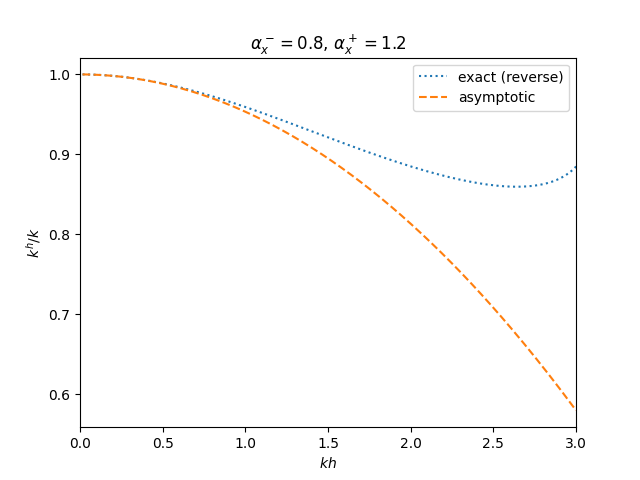

In [173]:
plot2_1D(ALPHA_M=0.8, ALPHA_P=1.2)

We are now able to find the appropriate $\tau$ for nodal exactness and 

Avec notre manière d'intégrer et nos éléments,
$$
- k^2 = - k^2 (1 - \tau k^2)
$$

On peut directement trouver $\tau$ à partir de la relation de dispersion donnant $k^2$ dans le cas Galerkine.

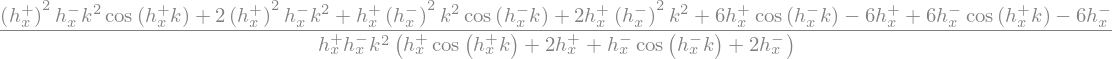

In [174]:
tau = sp.symbols('tau')
tauk2_GLS = sp.solve(k2_G.subs(kh, k)
                      +
                      (k**2)
                      *
                      (tau*(k**2) -1),
                       tau*(k**2))[0]
disp.display(tauk2_GLS)

Checking consistency with a uniform grid

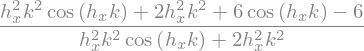

In [175]:
disp.display(tauk2_GLS.subs([(h_x_["+"], h_x),
                           (h_x_["-"], h_x),
                           ]).cancel())